<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
import os
import sys
import json

import statistics
import collections
import operator
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib.patches as mpatches

from collections import Counter
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from  matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

In [2]:
tracks = pd.read_csv('../../data/fma_metadata/new_tracks.csv', index_col=0, header=[0, 1])
tracks.shape

tracks[('track', 'date_created_year')] = \
                                        tracks[('track', 'date_created_year')].astype(str)
tracks.shape

(103708, 12)

In [3]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   (track, genre_top)            103708 non-null  object
 1   (set, split)                  103708 non-null  object
 2   (track, bit_rate)             103708 non-null  int64 
 3   (track, duration)             103708 non-null  int64 
 4   (track, listens)              103708 non-null  int64 
 5   (track, date_created_year)    103708 non-null  object
 6   (track, date_created_season)  103708 non-null  object
 7   (artist, id)                  103708 non-null  int64 
 8   (artist, favorites)           103708 non-null  int64 
 9   (album, id)                   103708 non-null  int64 
 10  (album, favorites)            103708 non-null  int64 
 11  (album, type)                 103708 non-null  object
dtypes: int64(7), object(5)
memory usage: 10.3+ MB


<h2> Librosa features </h2> 

For each 106,572 tracks, we have 518 Librosa features, having the following cardinalities:

1. **chroma_cens** = 12
2. **chroma_cqt** = 12
3. **chroma_stft** = 12
4. **mfcc** = 20
5. **rmse** = 1
6. **spectral_bandwidth** = 1
7. **spectral_centroid** = 1
8. **spectral_contrast** = 7
9. **spectral_rolloff** = 1
10. **tonnetz** = 6
11. **zcr** = 1

and for each cardinality feature we have the following information:
1. **min** = min feature's value;
2. **max** = max feature's value;
3. **median** = median feature's value;
4. **mean** = avg feature's values;
5. **std** = std feature's values;
6. **skew** = feature's values asymmetry distribution
7. **kurtosis** = feature's values tailedness distribution

In [4]:
librosaFeatures = pd.read_csv('../../data/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
librosaFeatures.shape

(106574, 518)

In [5]:
librosaFeatures.head(2).T

track_id                              2         3
feature     statistics number                    
chroma_cens kurtosis   01      7.180653  1.888963
                       02      5.230309  0.760539
                       03      0.249321  0.345297
                       04      1.347620  2.295201
                       05      1.482478  1.654031
...                                 ...       ...
zcr         mean       01      0.085629  0.084578
            median     01      0.071289  0.063965
            min        01      0.000000  0.000000
            skew       01      2.089872  1.716724
            std        01      0.061448  0.069330

[518 rows x 2 columns]

In [6]:
librosa_columns = {}
librosa_columns_info = set()
for c in librosaFeatures.columns:
    librosa_columns_info.add(c[1])
    try:
        if librosa_columns[str(c[0])] < c[2]:
            librosa_columns[str(c[0])] = c[2]
    except KeyError:
        librosa_columns[str(c[0])] = c[2]
print("Librosa columns:", librosa_columns)
print("Librosa columns info:", librosa_columns_info)

Librosa columns: {'chroma_cens': '12', 'chroma_cqt': '12', 'chroma_stft': '12', 'mfcc': '20', 'rmse': '01', 'spectral_bandwidth': '01', 'spectral_centroid': '01', 'spectral_contrast': '07', 'spectral_rolloff': '01', 'tonnetz': '06', 'zcr': '01'}
Librosa columns info: {'median', 'std', 'min', 'kurtosis', 'max', 'mean', 'skew'}


<h6>Keeping only 'mean' columns</h6> 

In [7]:
mean_columns = []
mean_features = []
one_nine_numbers = list(range(1, 10))
for key, value in librosa_columns.items():
    for n in range(1, int(value) + 1):
        n = str(n)
        if int(n) in one_nine_numbers:
            n = "0" + n
        column_name = key + "_" + n
        mean_columns.append(column_name)
        tmp_serie = librosaFeatures[key]['mean'][n]
        mean_features.append(tmp_serie)

librosaMeanFeatures = pd.concat(mean_features, axis=1,)
librosaMeanFeatures.shape

(106574, 74)

In [8]:
# rename concatenated DataFrame's columns
librosaMeanFeatures.columns = list(mean_columns)

In [9]:
# librosaMeanFeatures.info()

<h2> Pearson correlation</h2>

Exploiting the idea found here: https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6 and imposing a correlation threshold of +0.50 (-0.50), we deleted 42 librosa features out of 74.

In the classification tasks we will perform more advanced feature selection methods, in the attempt to lower dataset's heterogeneous features.

In [10]:
def normalize_df(df, scaler_flag):
    # for column_name in columns_to_normalize:
    column_names = list(df.columns)
    for column_name in column_names:
        data = df[column_name]
        scaler = None
        if scaler_flag == "min_max":
            scaler = MinMaxScaler()
        elif scaler_flag == "standard":
            scaler = StandardScaler()
        elif scaler_flag == "maxabs":
            scaler = MaxAbsScaler()
        elif scaler_flag == "robust":
            scaler = RobustScaler()
        else:
            print("scaler_flag error")
            sys.exit(-1)
        # fit the model on the feature to normale its values and transform it
        df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
    return df

In [11]:
def corrX_orig(df, cut = 0.9) :
    """
    https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
    """
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()

        
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
    # Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [12]:
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

In [13]:
def corrX_new(df, cut = 0.9) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

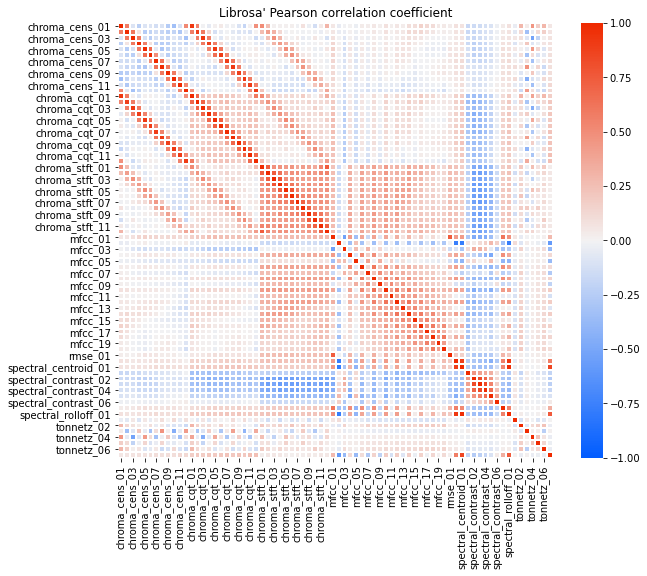

In [14]:
norm_librosaMeanFeatures = normalize_df(librosaMeanFeatures, "min_max")
corr = norm_librosaMeanFeatures.corr()

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, 
                                                                              square=True, linewidths=1, ax=ax)

plt.xlabel("")
plt.ylabel("")
plt.title("Librosa' Pearson correlation coefficient")
plt.show()

In [15]:
# old_drop = corrX_orig(norm_librosaMeanFeatures, cut = 0.5)
# remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(old_drop))))
# print("remanining_columns", len(remanining_columns))
# remanining_columns

In [16]:
# old_drop = corrX_orig(norm_librosaMeanFeatures, cut = 0.6)
# remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(old_drop))))
# print("remanining_columns", len(remanining_columns))
# remanining_columns

In [17]:
new_drop = corrX_new(norm_librosaMeanFeatures, cut = 0.60)
remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(new_drop))))
print("remanining_columns", len(remanining_columns))
remanining_columns

remanining_columns 43


['chroma_cens_01',
 'chroma_cens_03',
 'chroma_cens_04',
 'chroma_cens_06',
 'chroma_cens_07',
 'chroma_cens_09',
 'chroma_cens_11',
 'chroma_cens_12',
 'chroma_cqt_02',
 'chroma_stft_03',
 'chroma_stft_05',
 'chroma_stft_08',
 'chroma_stft_10',
 'chroma_stft_12',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_06',
 'mfcc_07',
 'mfcc_09',
 'mfcc_10',
 'mfcc_11',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_19',
 'mfcc_20',
 'rmse_01',
 'spectral_contrast_01',
 'spectral_contrast_03',
 'spectral_contrast_05',
 'spectral_contrast_06',
 'spectral_contrast_07',
 'tonnetz_01',
 'tonnetz_02',
 'tonnetz_03',
 'tonnetz_04',
 'tonnetz_05',
 'tonnetz_06',
 'zcr_01']

In [18]:
new_drop = corrX_new(norm_librosaMeanFeatures, cut = 0.50)
remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(new_drop))))
print("remanining_columns", len(remanining_columns))
remanining_columns

remanining_columns 32


['chroma_cens_02',
 'chroma_cens_04',
 'chroma_cens_06',
 'chroma_cens_07',
 'chroma_cens_09',
 'chroma_cens_11',
 'chroma_stft_05',
 'chroma_stft_08',
 'chroma_stft_10',
 'chroma_stft_12',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_07',
 'mfcc_08',
 'mfcc_09',
 'mfcc_14',
 'mfcc_15',
 'mfcc_19',
 'mfcc_20',
 'rmse_01',
 'spectral_contrast_01',
 'spectral_contrast_05',
 'spectral_contrast_06',
 'spectral_contrast_07',
 'tonnetz_01',
 'tonnetz_02',
 'tonnetz_03',
 'tonnetz_04',
 'tonnetz_05',
 'tonnetz_06']

Exploiting the idea found here: https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6 and imposing a correlation threshold of +0.50 (-0.50), we deleted 42 librosa features out of 74.

<h2>Merging librosa and tracks datasets</h2>

In [19]:
filtered_librosaMeanFeatures = librosaMeanFeatures[remanining_columns].copy()
filtered_librosaMeanFeatures.shape

(106574, 32)

In [20]:
tracks_librosaMeanFeatures = pd.merge(filtered_librosaMeanFeatures, tracks, left_index=True, right_index=True) 
tracks_librosaMeanFeatures.shape

/home/alexandra/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(103708, 44)

In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_tracks = tracks.select_dtypes(include=numerics)
numeric_tracks_librosaMeanFeatures = tracks_librosaMeanFeatures.select_dtypes(include=numerics)
del numeric_tracks[('album', 'id')]
del numeric_tracks[('artist', 'id')]
# del numeric_tracks[('track', 'date_created_year')]
del numeric_tracks_librosaMeanFeatures[('album', 'id')]
del numeric_tracks_librosaMeanFeatures[('artist', 'id')]
# del numeric_tracks_librosaMeanFeatures[('track', 'date_created_year')]
numeric_tracks_librosaMeanFeatures.shape

(103708, 37)

<h6>Checking if among librosa and tracks features exist some correlations</h6>

In [22]:
norm_numeric_tracks = numeric_tracks_librosaMeanFeatures.dropna().copy()  # N.B. = removing NaN values
# del norm_numeric_tracks[('track', 'date_created_year')]
norm_numeric_tracks = normalize_df(norm_numeric_tracks, "min_max")
corr = norm_numeric_tracks.corr()

In [23]:
# investigating negative correlation
threshold = -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] <= threshold):
            if corr.columns[i] in numeric_tracks or  corr.columns[j] in numeric_tracks:
                print(corr.columns[i], corr.columns[j], round(corr.iloc[i, j], 2), sep="\t")

In [24]:
# investigating positive correlation
threshold = 0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            if corr.columns[i] in numeric_tracks or  corr.columns[j] in numeric_tracks:
                print(corr.columns[i], corr.columns[j], "+" + str(round(corr.iloc[i, j], 2)), sep="\t")

Tracks and Librosa features aren't correlated.

<h2>Saving our final dataset on file</h2>

In [25]:
# rename columns
new_columns_names = []
for column_name in tracks_librosaMeanFeatures.columns:
    if "," in str(column_name):
        tmp = str(column_name).replace("(", "").replace(")", "").replace("\'", "").replace(" ", "")
        tmp_list = tmp.split(",")
        new_name = str(tmp_list[0]) + "_" + str(tmp_list[1])
        new_columns_names.append(new_name)
    else:
        new_columns_names.append(column_name)
        
# assigning new name to columns
tracks_librosaMeanFeatures.columns = new_columns_names

In [26]:
# saving our dataset of file
tracks_librosaMeanFeatures.to_csv('../../data/fma_metadata/group_20_fma.csv', index=True, header=True)

<h2>Album type librosa features insight</h2>

In [27]:
def sns_countplot(df, column_name, ax, log_flag, horizontal_flag):
      
    # create a list to collect the plt.patches data
    percentages = []
    # find the values and append to list
    for value in reversed(df[column_name].value_counts().index):
        perc = df[df[column_name] == value].shape[0] / df.shape[0]*100
        percentages.append(perc)
    
    if horizontal_flag:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(y=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(y=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
        
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
            
        # set individual bar lables using above list
        for i, perc  in zip(ax.patches, percentages):
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+100, i.get_y()+.18, "%.1f%%" % perc)
        # invert for largest on top 
        ax.invert_yaxis()
        
    else:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(x=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(x=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
            
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
        plt.xticks(sorted(list(df[column_name].dropna().unique())))
        
    plt.title("%s distribution" % str(column_name))
    if "AxesSubplot" not in str(ax):
        plt.show()

In [28]:
def sns_boxplot_ordered_by_mean(df, category_name, numerical_name, ax, horizontal_flag, showfliers):
    grouped = df.loc[:,[category_name, numerical_name]].dropna() \
    .groupby([category_name]) \
    .mean() \
    .sort_values(by=numerical_name)
    
    plt.title("%s per %s distribution" % (str(numerical_name), str(category_name)))
    if horizontal_flag:
        x = df[numerical_name]
        y = df[category_name]
    else:
        y = df[numerical_name]
        x = df[category_name]
        plt.xticks(rotation=90)
    if "AxesSubplot" not in str(ax):
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers)
        plt.show()
    else:
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers, ax=ax)

In [29]:
def draw_reversed_frequency_stacked_bar(df, column_name1, column_name2, y_log_flag, x_rotate_flag,
                                                                                annotate_top_perc_flag, ax):
    alphabetical_genres = sorted(df[column_name1].dropna().unique())
    
     # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    
    # compute a stacked bar with decreasing frequency for each unique value in column_name1
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
    
    # draw stacked bars
    colors_dict = {}
    curr_df = df[[column_name1, column_name2]].dropna()
    for i in range(0, num_rows):
        y = ordered_rows[i]
        x = [alphabetical_genres[i]]*len(y)
        label = ordered_columns[i]
        colors, colors_dict = get_colors_list(pclass_xt.columns, label)
        bottoms = [0]  # first bar drawn at y=0
        for j in range(1, len(y)):
            j_1_elements_sum = sum(y[:j])
            bottoms.append(j_1_elements_sum)
            
        tot_elems =  sum(y)
        perc = "{:.0f}%".format(int(tot_elems) / curr_df.shape[0]*100)
        
        if "AxesSubplot" not in str(ax):
            if annotate_top_perc_flag:
                plt.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms)
        else:
            if annotate_top_perc_flag:
                ax.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms, ax=ax)
            
    # self-created legend
    handles = []
    for key, value in colors_dict.items():
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch)
    plt.legend(title=column_name2, handles=handles, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    if x_rotate_flag:
        plt.xticks(rotation=90)
    if y_log_flag:
        plt.yscale("log")
    plt.xlabel(column_name1)
    plt.ylabel("count")
    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    
    if "AxesSubplot" not in str(ax):
        plt.show()
    
    return pclass_xt

In [30]:
def print_perc_column(df, column_name):
    print("%s:" % str(column_name))
    tmp_serie = df[column_name].dropna()
    counter = Counter(tmp_serie)
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    tot_values = sum(sorted_counter.values())
    for k, v in sorted_counter.items():
        perc = v / tot_values * 100
        print(k, "%.1f%%" % perc, sep="\t")
    print()

In [31]:
def print_hues_perc_column(df, column_name, hue):
    print("%s" % str(column_name) + " per %s:" % str(hue))
    for genre in df[hue].dropna().unique():
        tmp_serie = df[(df[hue] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in df[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        first_k = next(iter(sorted_counter.keys()))
        first_v = next(iter(sorted_counter.values()))
        perc = first_v / tot_values * 100
        print(genre, first_k, "%.1f%%" % perc, sep="\t")

In [32]:
def print_hues_all_perc_column(df, column_name, hue):
    print("%s" % str(column_name) + " per %s:" % str(hue))
    for genre in df[hue].dropna().unique():
        tmp_serie = df[(df[hue] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in df[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        for k, v in sorted_counter.items():
            perc = v / tot_values * 100
            print(genre, k, "%.1f%%" % perc, sep="\t")
        print()

In [33]:
def genre_zero_frequency_table_insight(frequency_table, df, column_name, hue):
    alphabetical_genres = sorted(df[hue].dropna().unique())
    
    print("%s's zero values:" % str(column_name))
    for column_name in frequency_table.columns:
        zero_genres = []
        for i in range(0, len(alphabetical_genres)):
            tmp_list = list(frequency_table[column_name])
            if tmp_list[i] == 0:
                zero_genres.append(alphabetical_genres[i])
        if len(zero_genres) > 0:
            print(column_name, zero_genres)

In [34]:
def genre_max_frequency_table_insight(frequency_table, df, column_name, hue):
    alphabetical_genres = sorted(df[hue].dropna().unique())
    
    print("%s's max values:" % str(column_name))
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
        
        first_value = sorted_g_values[0]
        first_column = sorted_g_first_columns[0]
        greates_values = [(first_column, first_value)]
        for j in range(1, num_column):
            other_value = sorted_g_values[j]
            other_column = sorted_g_first_columns[j]
            if other_value == first_value:
                greates_values.append((other_column, other_value))
            else:
                break
        genre = alphabetical_genres[i]
        try:
            perc = greates_values[0][1] / df[df[hue] == genre].shape[0] * 100
        except ZeroDivisionError:
            perc = 0.0
        print(genre, greates_values, "%.1f%%" % perc, sep="\t")

In [35]:
"""column_name1 = ('album', 'type')

for column_name2 in remanining_columns:
    fig = plt.subplots(figsize=(20, 5))
    fig_dims = (1, 3)

    ax = plt.subplot2grid(fig_dims, (0, 0))
    sns_countplot(tracks_librosaMeanFeatures, column_name2, ax, False, True)
    ax = plt.subplot2grid(fig_dims, (0, 1))
    sns_boxplot_ordered_by_mean(tracks_librosaMeanFeatures, column_name1, column_name2, ax, False, False)
    ax = plt.subplot2grid(fig_dims, (0, 2))
    pclass_xt = draw_reversed_frequency_stacked_bar(tracks_librosaMeanFeatures, column_name1, column_name2, False, True, True, "")
    plt.show()
    # print_perc_column(tracks_librosaMeanFeatures, column_name2)
    # print_hues_perc_column(tracks_librosaMeanFeatures, column_name2, column_name1)
    # print_hues_all_perc_column(tracks_librosaMeanFeatures, column_name2, column_name1)
    # genre_zero_frequency_table_insight(pclass_xt,  tracks_librosaMeanFeatures, column_name2, column_name1)
    genre_max_frequency_table_insight(pclass_xt,  tracks_librosaMeanFeatures, column_name2, column_name1)"""

'column_name1 = (\'album\', \'type\')\n\nfor column_name2 in remanining_columns:\n    fig = plt.subplots(figsize=(20, 5))\n    fig_dims = (1, 3)\n\n    ax = plt.subplot2grid(fig_dims, (0, 0))\n    sns_countplot(tracks_librosaMeanFeatures, column_name2, ax, False, True)\n    ax = plt.subplot2grid(fig_dims, (0, 1))\n    sns_boxplot_ordered_by_mean(tracks_librosaMeanFeatures, column_name1, column_name2, ax, False, False)\n    ax = plt.subplot2grid(fig_dims, (0, 2))\n    pclass_xt = draw_reversed_frequency_stacked_bar(tracks_librosaMeanFeatures, column_name1, column_name2, False, True, True, "")\n    plt.show()\n    # print_perc_column(tracks_librosaMeanFeatures, column_name2)\n    # print_hues_perc_column(tracks_librosaMeanFeatures, column_name2, column_name1)\n    # print_hues_all_perc_column(tracks_librosaMeanFeatures, column_name2, column_name1)\n    # genre_zero_frequency_table_insight(pclass_xt,  tracks_librosaMeanFeatures, column_name2, column_name1)\n    genre_max_frequency_table_i

In [192]:
from math import pi
from sklearn.preprocessing import MinMaxScaler

def plot_radar(df, categories, scaler_flag):
    
    df_curr = df.copy()
    for column_name in categories:
            if column_name == 'track_date_created_season':
                cleanup_nums = {'track_date_created_season':{"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4}}        
                df_curr = df_curr.replace(cleanup_nums)
    
   
    if scaler_flag:
        df_curr = df_curr[categories]
        for column_name in categories:
            scaler = MinMaxScaler()
            df_curr[column_name] = scaler.fit_transform(df_curr[column_name].values.reshape(-1,1))[:, 0] 
        df_curr.insert(loc=0, column='album_type', value=df['album_type'].values)
        
    # number of variable
    N = len(categories) 

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    #ax = plt.subplot(111, polar=True)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Ind1
    target_column = 'album_type'
    features = []
    for column_name in categories:
        tmp = np.median(df_curr[df_curr[target_column] == "Studio Recording"][column_name])
        features.append(tmp)
    features.append(features[0])

    ax.plot(angles, features, linewidth=1, linestyle='solid', label="Studio Recording")
    ax.fill(angles, features, 'b', alpha=0.1)

    # Ind2
    target_column = 'album_type'
    features = []
    for column_name in categories:
        tmp = np.median(df_curr[df_curr[target_column] == "Live Recording"][column_name])
        features.append(tmp)
    features.append(features[0])
        
    ax.plot(angles, features, linewidth=1, linestyle='solid', label="Live Recording")
    ax.fill(angles, features, 'orange', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title('Album types and features')

    # Show the graph
    plt.show()

In [254]:
from math import pi
from sklearn.preprocessing import MinMaxScaler

def plot_radar2(df, categories, label, scaler_flag, title):
    
    df_curr = df.copy()
    df_curr = df_curr[categories]
    df_curr.insert(loc=0, column='album_type', value=df['album_type'].values)
    
    if 'track_date_created_season' in df_curr.columns:
        cleanup_nums = {'track_date_created_season':{"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4}}        
        df_curr = df_curr.replace(cleanup_nums)
    if 'track_genre_top' in df_curr:
        cleanup_nums = {'track_genre_top':{'Hip-Hop':1, 'Pop':2, 'Experimental':3, 'Folk':4, 
                                                     'Jazz':5, 'Rock':6, 'Electronic':7, 
                                                     'Spoken':8, 'International':9, 
                                                     'Soul-RnB':10, 'Blues':11,
                                                     'Classical':12, 'Country':13,
                                                     'Old-Time / Historic':14, 
                                                     'Easy Listening':15, 'Instrumental':16}}        
        df_curr = df_curr.replace(cleanup_nums)
    
    if scaler_flag:
        for column_name in categories:
            if column_name in librosaMeanFeatures:
                continue
            scaler = MinMaxScaler()
            df_curr[column_name] = scaler.fit_transform(df_curr[column_name].values.reshape(-1,1))[:, 0] 
        
    # number of variable
    N = len(categories) 

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    #ax = plt.subplot(111, polar=True)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, fontsize=8)

    # Ind1
    target_column = 'album_type'
    color = 'b'
    if label == 'Live Recording':
        color = 'g'
    features = []
    for column_name in categories:
        tmp = np.median(df_curr[df_curr[target_column] == label][column_name])
        if label == 'Studio Recording':
            tmp += 0.1
        features.append(tmp)
    features.append(features[0])

    if color == 'b':
        ax.plot(angles, features, linewidth=1, linestyle='solid', label=label)
    else:
        ax.plot(angles, features, linewidth=1, linestyle='solid', label=label, color=color)
    ax.fill(angles, features, color, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title(title)

    # Show the graph
    plt.show()

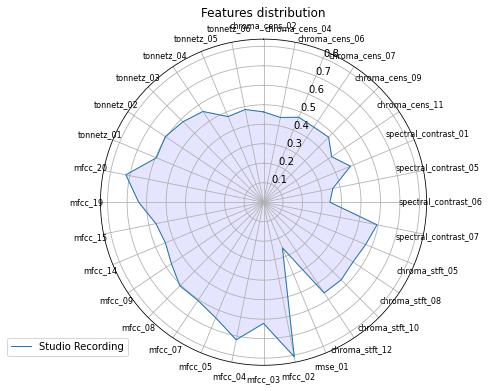

In [255]:
categories = []
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", 'rmse_01', "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    if column_initial_name == 'rmse_01':
        categories.append(column_initial_name)
        continue
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Studio Recording', False, "Features distribution")

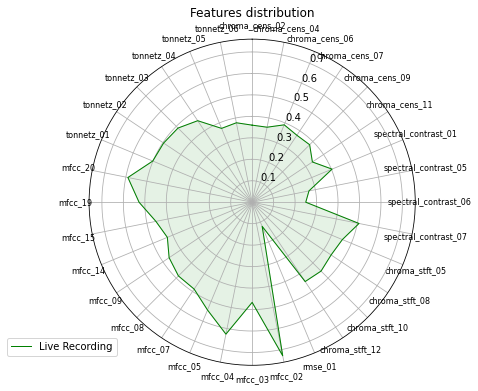

In [256]:
categories = []
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", 'rmse_01', "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    if column_initial_name == 'rmse_01':
        categories.append(column_initial_name)
        continue
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Live Recording', False, "Features distribution")

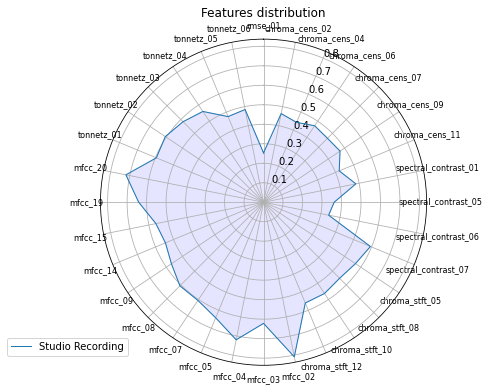

In [257]:
categories = ['rmse_01']
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Studio Recording', False, "Features distribution")

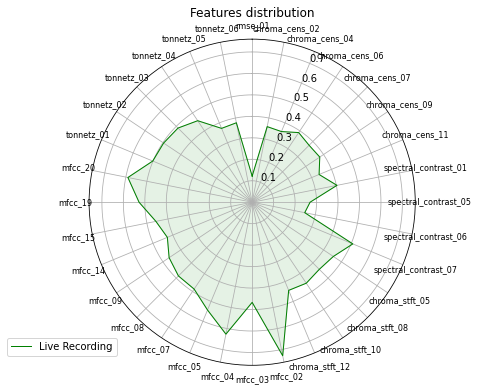

In [258]:
categories = ['rmse_01']
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Live Recording', False, "Features distribution")

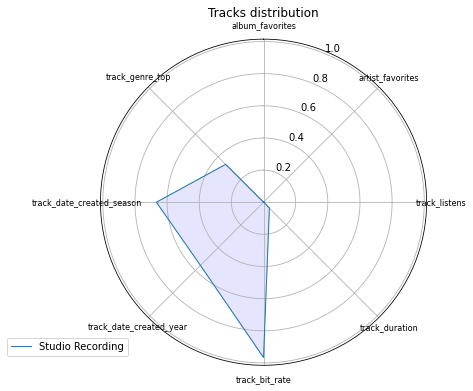

In [252]:
categories = ['album_favorites', 'artist_favorites', 'track_listens', 'track_duration', 'track_bit_rate',
              'track_date_created_year', 'track_date_created_season', 'track_genre_top']
plot_radar2(tracks_librosaMeanFeatures, categories, 'Studio Recording', True, "Tracks distribution")

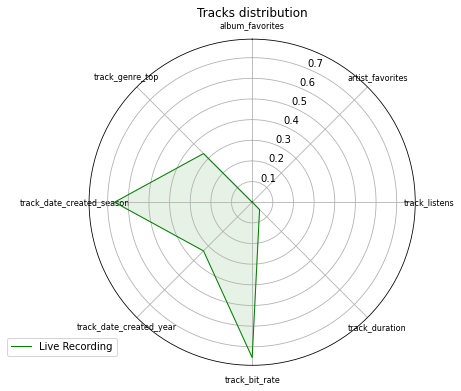

In [251]:
categories = ['album_favorites', 'artist_favorites', 'track_listens', 'track_duration', 'track_bit_rate',
              'track_date_created_year', 'track_date_created_season', 'track_genre_top']
plot_radar2(tracks_librosaMeanFeatures, categories, 'Live Recording', True, "Tracks distribution")

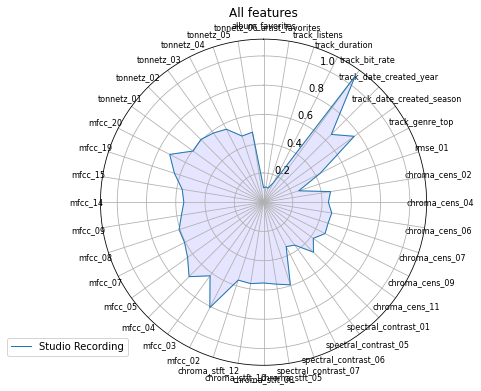

In [227]:
categories = ['album_favorites', 'artist_favorites', 'track_listens', 'track_duration', 'track_bit_rate',
              'track_date_created_year', 'track_date_created_season', 'track_genre_top', 'rmse_01']
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Studio Recording', True, "All features")

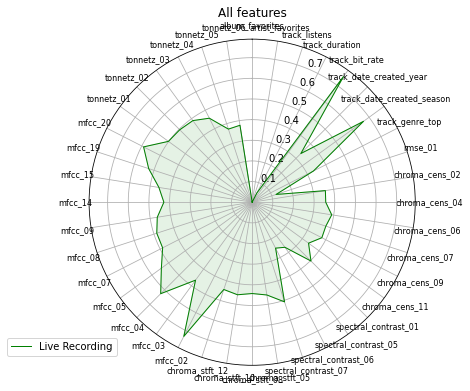

In [228]:
categories = ['album_favorites', 'artist_favorites', 'track_listens', 'track_duration', 'track_bit_rate',
              'track_date_created_year', 'track_date_created_season', 'track_genre_top', 'rmse_01']
column_initial_names = ["chroma_cens", "spectral_contrast", "chroma_stft", "mfcc", "tonnetz"]
for column_initial_name in column_initial_names:
    tmp_list =  [x for x in tracks_librosaMeanFeatures.columns if column_initial_name in x]
    categories = categories + tmp_list
plot_radar2(tracks_librosaMeanFeatures, categories, 'Live Recording', True, "All features")

<h6>Checking album type in echonest dataset </h6>

In [130]:
echonestData = pd.read_csv('../../data/fma_metadata/echonest.csv', index_col=0, header=[0, 1, 2])
echonestData.shape

(13129, 249)

In [131]:
audioFeatures = echonestData['echonest']['audio_features']
audioFeatures.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [134]:
audioFeatures_indeced = list(audioFeatures.index)
len(audioFeatures_indeced)

13129

In [135]:
tracks_indeced = list(tracks.index)
len(tracks_indeced)

103708

In [142]:
count = 0
for idx in audioFeatures_indeced:
    try:
        tmp_list.append(tracks.at[idx, ('album', 'type')])
    except KeyError:
        continue
Counter(tmp_list)

Counter({'Studio Recording': 19702, 'Live Recording': 6238})

In [145]:
audioFeatures_new = pd.merge(audioFeatures, tracks, left_index=True, right_index=True) 
# rename columns
new_columns_names = []
for column_name in audioFeatures_new.columns:
    if "," in str(column_name):
        tmp = str(column_name).replace("(", "").replace(")", "").replace("\'", "").replace(" ", "")
        tmp_list = tmp.split(",")
        new_name = str(tmp_list[0]) + "_" + str(tmp_list[1])
        new_columns_names.append(new_name)
    else:
        new_columns_names.append(column_name)
        
# assigning new name to columns
audioFeatures_new.columns = new_columns_names
audioFeatures_new.shape

(12970, 20)

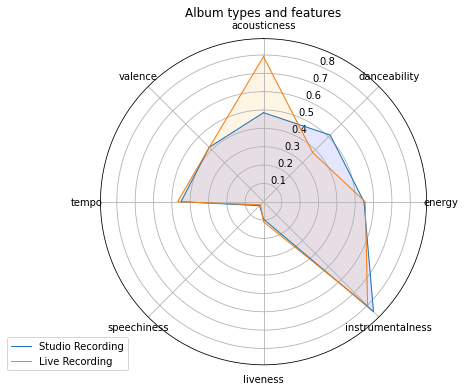

In [149]:
categories = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness",
             "tempo", "valence"]
plot_radar(audioFeatures_new, categories, True)

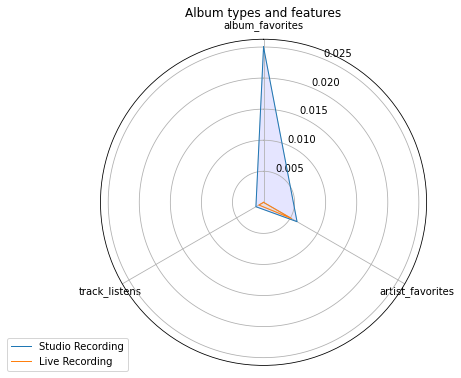

In [154]:
categories = ['album_favorites', 'artist_favorites', 'track_listens']
plot_radar(audioFeatures_new, categories, True)

<h2> Preparing dataset for classification </h2>

We divide the dataset in **trai, validation, train_merged (train + validation) and test** to perform our classification tasks. This division is derived uppon "set_split" column, since both class labels show a stratified representation in each fold.

We also encode our categorical variables, using:
- onehot-encoding for 'track_genre_top';
- ordinal-encoding for 'track_date_created_year' and 'track_date_created_season';
- binary-encoding for 'album_type'.

In [36]:
def print_encoding(column_name, encoder_categories):
    """
    Function which prints the encoding undergone
    """
    print("%s's values encoded as:" % column_name)
    for i in range(0, len(encoder_categories[0])):
        print("%s" % encoder_categories[0][i], "%d" % i, sep="\t")

In [37]:
def replace_categorical_feature_with_dummy_ones(df, column_name, categories_list, dummy_features):
    """
    Function which replaces the nominal feature passed by argument with dummy ones, 
    to convert nominal column's M values in M new binary (dummy) features.
    """
    # retrive nominal feature's index. It is used to know where to insert the new M binary features
    index = df.columns.get_loc(column_name)
    for i in range(0, dummy_features.shape[1]):
        index += 1
        df.insert(index, column_name + "_" + str(categories_list[i].replace(" ", "_")), 
                                                              dummy_features[:, i].todense().astype(int), True)
    # remove categorical feature
    del df[column_name]
    
    return df

In [38]:
def prepare_splits(df):
    target_column = 'album_type'
    
    train = df[df['set_split'] == 'training']
    validation = df[df['set_split'] == 'validation']
    test = df[df['set_split'] == 'test']
    train_merged = df[(df['set_split'] == 'training') | (df['set_split'] == 'validation')]

    not_target_columns = list(df.columns) 
    not_target_columns.remove('set_split')
    not_target_columns.remove('album_id')
    not_target_columns.remove('artist_id')
    not_target_columns.remove(target_column)

    X_train = train[not_target_columns]
    X_validation = validation[not_target_columns]
    X_test = test[not_target_columns]
    X_train_merged = train_merged[not_target_columns]    

    y_train = train[[target_column]]
    y_validation = validation[[target_column]]
    y_test = test[[target_column]]
    y_train_merged = train_merged[[target_column]] 
    
    if (X_train.shape[0] != y_train.shape[0]) or (X_validation.shape[0] != y_validation.shape[0]) or \
         (X_train_merged.shape[0] != y_train_merged.shape[0]) or (X_test.shape[0] != y_test.shape[0]):
        print("error in row shapes")
        sys.exit(-1)

    return X_train, X_validation, X_test, X_train_merged, y_train, y_validation, y_test, y_train_merged
                             
def prepare_dataset_for_classification(df, cat_conversion_flag):
    X_train, X_validation, X_test, X_train_merged, y_train, y_validation, y_test, y_train_merged = \
                                                                prepare_splits(df)
          
    target_column = 'album_type'
    categorical_columns = ['track_genre_top']
    categories_lists = [list(librosa_tracks['track_genre_top'].unique())]

    if cat_conversion_flag:
        # onehot encoding
        for column_name, categories_list in zip(categorical_columns, categories_lists):
            encoder = OneHotEncoder(categories=[categories_list])   
            dummy_features = encoder.fit_transform(X_train[column_name].values.reshape(-1,1))  
            replace_categorical_feature_with_dummy_ones(X_train, column_name, categories_list, dummy_features)

            dummy_features = encoder.transform(X_validation[column_name].values.reshape(-1,1))  
            replace_categorical_feature_with_dummy_ones(X_validation, column_name, categories_list, dummy_features)

            encoder = OneHotEncoder(categories=[categories_list])   
            dummy_features = encoder.fit_transform(X_train_merged[column_name].values.reshape(-1,1))  
            replace_categorical_feature_with_dummy_ones(X_train_merged, column_name, categories_list, dummy_features)

            dummy_features = encoder.transform(X_test[column_name].values.reshape(-1,1))  
            replace_categorical_feature_with_dummy_ones(X_test, column_name, categories_list, dummy_features)

            print_encoding(column_name, encoder.categories_)
            print()
            
        # ordinal encoding 
        cleanup_nums = {'track_date_created_season':{"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4},
                       'track_date_created_year':{2008: 1, 2009: 2, 2010: 3, 2011: 4, 2012: 5,
                                                  2013: 6, 2014: 7, 2015: 8, 2016: 9, 2017: 10}}        
        X_train = X_train.replace(cleanup_nums)
        X_validation = X_validation.replace(cleanup_nums)
        X_train_merged = X_train_merged.replace(cleanup_nums)
        X_test = X_test.replace(cleanup_nums)

        # binary encoding
        encoder = OrdinalEncoder(categories=[['Studio Recording', 'Live Recording']])  
        y_train[target_column] = encoder.fit_transform(y_train[target_column].values.reshape(-1,1))[:,0].astype(int)
        y_validation[target_column] = encoder.transform(y_validation[target_column].values.reshape(-1,1))[:,0].astype(int)

        y_train_merged[target_column] = encoder.fit_transform(y_train_merged[target_column].values.reshape(-1,1))[:,0].astype(int)
        y_test[target_column] = encoder.transform(y_test[target_column].values.reshape(-1,1))[:,0].astype(int)

    
    return X_train, X_validation, X_test, X_train_merged, y_train, y_validation, y_test, y_train_merged

In [39]:
# checking
librosa_tracks = pd.read_csv('../../data/fma_metadata/group_20_fma.csv', index_col=0)
librosa_tracks.shape

(103708, 44)

In [40]:
X_train, X_validation, X_test, X_train_merged, y_train, y_validation, y_test, y_train_merged = \
                                                    prepare_dataset_for_classification(librosa_tracks, True)

track_genre_top's values encoded as:
Hip-Hop	0
Pop	1
Experimental	2
Folk	3
Jazz	4
Rock	5
Electronic	6
Spoken	7
International	8
Soul-RnB	9
Blues	10
Classical	11
Country	12
Old-Time / Historic	13
Easy Listening	14
Instrumental	15



In [41]:
# saving our dataset of file
X_train.to_csv('../../data/fma_metadata/X_train.csv', index=True, header=True)
X_validation.to_csv('../../data/fma_metadata/X_validation.csv', index=True, header=True)
X_train_merged.to_csv('../../data/fma_metadata/X_train_merged.csv', index=True, header=True)
X_test.to_csv('../../data/fma_metadata/X_test.csv', index=True, header=True)

y_train.to_csv('../../data/fma_metadata/y_train.csv', index=True, header=True)
y_validation.to_csv('../../data/fma_metadata/y_validation.csv', index=True, header=True)
y_train_merged.to_csv('../../data/fma_metadata/y_train_merged.csv', index=True, header=True)
y_test.to_csv('../../data/fma_metadata/y_test.csv', index=True, header=True)

In [45]:
# trasform categorical/ordinal variables also in final dataset
numeric_librosa_tracks = librosa_tracks.copy()

target_column = 'album_type'
categorical_columns = ['track_genre_top']
categories_lists = [list(librosa_tracks['track_genre_top'].unique())]

# onehot encoding
for column_name, categories_list in zip(categorical_columns, categories_lists):
    encoder = OneHotEncoder(categories=[categories_list])   
    dummy_features = encoder.fit_transform(numeric_librosa_tracks[column_name].values.reshape(-1,1))  
    replace_categorical_feature_with_dummy_ones(numeric_librosa_tracks, column_name, categories_list, dummy_features)

    print_encoding(column_name, encoder.categories_)
    print()

# ordinal encoding 
cleanup_nums = {'track_date_created_season':{"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4},
               'track_date_created_year':{2008: 1, 2009: 2, 2010: 3, 2011: 4, 2012: 5,
                                          2013: 6, 2014: 7, 2015: 8, 2016: 9, 2017: 10}}        
numeric_librosa_tracks = numeric_librosa_tracks.replace(cleanup_nums)

# binary encoding
encoder = OrdinalEncoder(categories=[['Studio Recording', 'Live Recording']])  
numeric_librosa_tracks[target_column] = encoder.fit_transform(numeric_librosa_tracks[target_column].values.reshape(-1,1))[:,0].astype(int)

del numeric_librosa_tracks['album_id']
del numeric_librosa_tracks['artist_id']
del numeric_librosa_tracks['set_split']

track_genre_top's values encoded as:
Hip-Hop	0
Pop	1
Experimental	2
Folk	3
Jazz	4
Rock	5
Electronic	6
Spoken	7
International	8
Soul-RnB	9
Blues	10
Classical	11
Country	12
Old-Time / Historic	13
Easy Listening	14
Instrumental	15



In [47]:
# saving our dataset of file
numeric_librosa_tracks.to_csv('../../data/fma_metadata/group_20_fma_numeric.csv', index=True, header=True)

<h1>VarianceThreshold</h1>

Since we have many features, we remove all features whose variance doesn’t meet some threshold. By default, VarianceThreshold removes all zero-variance features, i.e. features that have the same value in all samples.

<u>This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.</u>

In [92]:
from sklearn.feature_selection import VarianceThreshold

In [93]:
def retrieve_features_from_get_support(X_tr, mask):
    new_features = []
    for bool, feature in zip(mask, X_tr.columns):
        if bool:
            new_features.append(feature)
    return new_features

In [94]:
def variance_threshold_selection(X_tr, threshold, info_flag):
    variance_threshold_features = []
    selector = VarianceThreshold(threshold)
    selector.fit(X_tr)
    print("Threshold", threshold)
    if info_flag:
        print('Number of features used... ', Counter(selector.get_support())[True])
        print('Number of features ignored... ', Counter(selector.get_support())[False])
    else:
        mask = selector.get_support()
        variance_threshold_features = retrieve_features_from_get_support(X_tr, mask)
        print('Features used...\n', '\n'.join(variance_threshold_features))
    print()
    return selector, variance_threshold_features

<h6> X_train </h6>

In [95]:
#Learn the features to filter from train set
# thresholds = list(np.linspace(0, 1, 11))
thresholds = list(np.linspace(0, 0.2, 21))
for t in thresholds:
    selector, _ = variance_threshold_selection(X_train, t, True)

Threshold 0.0
Number of features used...  55
Number of features ignored...  0

Threshold 0.01
Number of features used...  28
Number of features ignored...  27

Threshold 0.02
Number of features used...  17
Number of features ignored...  38

Threshold 0.03
Number of features used...  15
Number of features ignored...  40

Threshold 0.04
Number of features used...  15
Number of features ignored...  40

Threshold 0.05
Number of features used...  13
Number of features ignored...  42

Threshold 0.06
Number of features used...  11
Number of features ignored...  44

Threshold 0.07
Number of features used...  11
Number of features ignored...  44

Threshold 0.08
Number of features used...  10
Number of features ignored...  45

Threshold 0.09
Number of features used...  10
Number of features ignored...  45

Threshold 0.1
Number of features used...  10
Number of features ignored...  45

Threshold 0.11
Number of features used...  10
Number of features ignored...  45

Threshold 0.12
Number of featur

In [96]:
selector1, variance_threshold_features1 = variance_threshold_selection(X_train, 0.01, False)

Threshold 0.01
Features used...
 chroma_cens_02
chroma_cens_06
chroma_cens_07
chroma_cens_09
chroma_stft_05
chroma_stft_08
chroma_stft_10
chroma_stft_12
mfcc_03
spectral_contrast_07
track_genre_top_Hip-Hop
track_genre_top_Pop
track_genre_top_Experimental
track_genre_top_Folk
track_genre_top_Jazz
track_genre_top_Rock
track_genre_top_Electronic
track_genre_top_International
track_genre_top_Soul-RnB
track_genre_top_Classical
track_genre_top_Instrumental
track_bit_rate
track_duration
track_listens
track_date_created_year
track_date_created_season
artist_favorites
album_favorites



In [97]:
selector2, variance_threshold_features2 = variance_threshold_selection(X_train, 0.02, False)

Threshold 0.02
Features used...
 spectral_contrast_07
track_genre_top_Hip-Hop
track_genre_top_Pop
track_genre_top_Experimental
track_genre_top_Folk
track_genre_top_Rock
track_genre_top_Electronic
track_genre_top_International
track_genre_top_Classical
track_genre_top_Instrumental
track_bit_rate
track_duration
track_listens
track_date_created_year
track_date_created_season
artist_favorites
album_favorites



In [98]:
count = 0
for elem in variance_threshold_features1:
    if 'track_genre_top_' in elem:
        count += 1
count

11

In [99]:
set(variance_threshold_features1).difference(set(variance_threshold_features2))

{'chroma_cens_02',
 'chroma_cens_06',
 'chroma_cens_07',
 'chroma_cens_09',
 'chroma_stft_05',
 'chroma_stft_08',
 'chroma_stft_10',
 'chroma_stft_12',
 'mfcc_03',
 'track_genre_top_Jazz',
 'track_genre_top_Soul-RnB'}

In [100]:
genre_columns = [c for c in X_train.columns if 'track_genre_top' in c]
set(genre_columns).difference(set(variance_threshold_features1))

{'track_genre_top_Blues',
 'track_genre_top_Country',
 'track_genre_top_Easy_Listening',
 'track_genre_top_Old-Time_/_Historic',
 'track_genre_top_Spoken'}

In [101]:
# retrieve choose threshold features
selector_trn, variance_threshold_features_trn = variance_threshold_selection(X_train, 0.01, False)

Threshold 0.01
Features used...
 chroma_cens_02
chroma_cens_06
chroma_cens_07
chroma_cens_09
chroma_stft_05
chroma_stft_08
chroma_stft_10
chroma_stft_12
mfcc_03
spectral_contrast_07
track_genre_top_Hip-Hop
track_genre_top_Pop
track_genre_top_Experimental
track_genre_top_Folk
track_genre_top_Jazz
track_genre_top_Rock
track_genre_top_Electronic
track_genre_top_International
track_genre_top_Soul-RnB
track_genre_top_Classical
track_genre_top_Instrumental
track_bit_rate
track_duration
track_listens
track_date_created_year
track_date_created_season
artist_favorites
album_favorites



Using a variance threshold of 0.02 we get only the features present in "tracks.csv" (a part from  spectral_contrast_07). With a threshold of 0.01 we can notice the introduction of some chroma_cens, chroma_stf and mfcc features.

However, we can notice that genres having a frequency lower than 1% in the dataset are still missing using 0.01 as variance threshold (Blues, Country, Easy_Listening, Old-Time/Historic, Spoken). The percentage frequency raises to 1.5% with 0.02 as threshold (Soul-RnB, Jazz).

This means that infreqeunt genres aren't used as classification traits, so we can dismiss them.

To avoid completly cutting out "features.csv"'s variables, **we will use a treshold of 0.01 as our first variance threshold selection method**

<h6>X_train_merged</h6>

In [102]:
#Learn the features to filter from train set
# thresholds = list(np.linspace(0, 1, 11))
thresholds = list(np.linspace(0, 0.2, 21))
for t in thresholds:
    selector, _ = variance_threshold_selection(X_train_merged, t, True)

Threshold 0.0
Number of features used...  55
Number of features ignored...  0

Threshold 0.01
Number of features used...  28
Number of features ignored...  27

Threshold 0.02
Number of features used...  17
Number of features ignored...  38

Threshold 0.03
Number of features used...  15
Number of features ignored...  40

Threshold 0.04
Number of features used...  15
Number of features ignored...  40

Threshold 0.05
Number of features used...  13
Number of features ignored...  42

Threshold 0.06
Number of features used...  11
Number of features ignored...  44

Threshold 0.07
Number of features used...  11
Number of features ignored...  44

Threshold 0.08
Number of features used...  10
Number of features ignored...  45

Threshold 0.09
Number of features used...  10
Number of features ignored...  45

Threshold 0.1
Number of features used...  10
Number of features ignored...  45

Threshold 0.11
Number of features used...  10
Number of features ignored...  45

Threshold 0.12
Number of featur

In [103]:
# retrieve choose threshold features
selector_trn_mrg, variance_threshold_features_trn_mrg = variance_threshold_selection(X_train_merged, 0.01, False)

Threshold 0.01
Features used...
 chroma_cens_02
chroma_cens_06
chroma_cens_07
chroma_cens_09
chroma_stft_05
chroma_stft_08
chroma_stft_10
chroma_stft_12
mfcc_03
spectral_contrast_07
track_genre_top_Hip-Hop
track_genre_top_Pop
track_genre_top_Experimental
track_genre_top_Folk
track_genre_top_Jazz
track_genre_top_Rock
track_genre_top_Electronic
track_genre_top_International
track_genre_top_Soul-RnB
track_genre_top_Classical
track_genre_top_Instrumental
track_bit_rate
track_duration
track_listens
track_date_created_year
track_date_created_season
artist_favorites
album_favorites



In [104]:
set(variance_threshold_features_trn).difference(set(variance_threshold_features_trn_mrg))

set()

In [105]:
set(variance_threshold_features_trn_mrg).difference(set(variance_threshold_features_trn))

set()

The same features filtered using a threshold of 0.01 are still present in the train+validation data.

In [106]:
X_train_vt = X_train[variance_threshold_features_trn]
X_validation_vt = X_validation[variance_threshold_features_trn]
X_train_merged_vt = X_train_merged[variance_threshold_features_trn_mrg]
X_test_vt = X_test[variance_threshold_features_trn_mrg]

In [107]:
# saving our dataset of file
X_train_vt.to_csv('../../data/fma_metadata/X_train_vt.csv', index=True, header=True)
X_validation_vt.to_csv('../../data/fma_metadata/X_validation_vt.csv', index=True, header=True)
X_train_merged_vt.to_csv('../../data/fma_metadata/X_train_merged_vt.csv', index=True, header=True)
X_test_vt.to_csv('../../data/fma_metadata/X_test_vt.csv', index=True, header=True)

<h6>ANOVA feature selection (filter method)</h6>
Importantly, ANOVA is used when one variable is numeric and one is categorical, such as numerical input variables and a classification target variable in a classification task.

ANOVA is an acronym for analysis of variance and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method is a type of F-statistic referred to here as an ANOVA F-test.

The scikit-learn machine library provides an implementation of the ANOVA F-test in the f classif() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

We cawilln systematically test a range of different numbers of selected features and discover which results in the best performing model. This is called a grid search, where the k argument to the SelectKBest class can be tuned. It is good practice to evaluate model configurations on classification tasks using repeated stratified k-fold cross-validation. We will use 3-fold cross-validation via the StratifiedKFold class.

Since both class labels are equally important and we assign equl cost to FN and FP, we will use as GridSearch's scoring metric the f1_weighted measure (we want a trade-off among precision and recall).

N.B.

f1_macro => unweighted class label
f1_weighted => weighted class label

In [108]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

In [109]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42
n_splits = 3

color = "#4C72B0"

In [110]:
def get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results, key):
    best_k = results.best_params_[key]
    if key == 'anova__k':
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe__n_features_to_select':
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.title("%s's %s feature importance" % (key.split('__')[0].upper(), v_or_t_flag))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [111]:
from scipy.stats import boxcox, shapiro, yeojohnson

def anova_feature_selection(X_tr, y_tr, v_or_t_flag):
    cv = StratifiedKFold(n_splits=n_splits)
    anova = SelectKBest(score_func=f_classif)
    pipeline = Pipeline(steps=[('anova', anova)])

    # define the grid to search:
    grid = dict()                          
    grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]

    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=False, random_state=random_state)

    # normalized data
    X_tr_norm = X_tr.apply(lambda x: yeojohnson(x)[0])
    # perform the search
    results = search.fit(X_tr_norm, y_tr.values.ravel())

    # summarize best
    params = results.best_params_
    print('Best Config: %s ' % params)
    best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results, 'anova__k')

    return best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Config: {'anova__k': 32} 


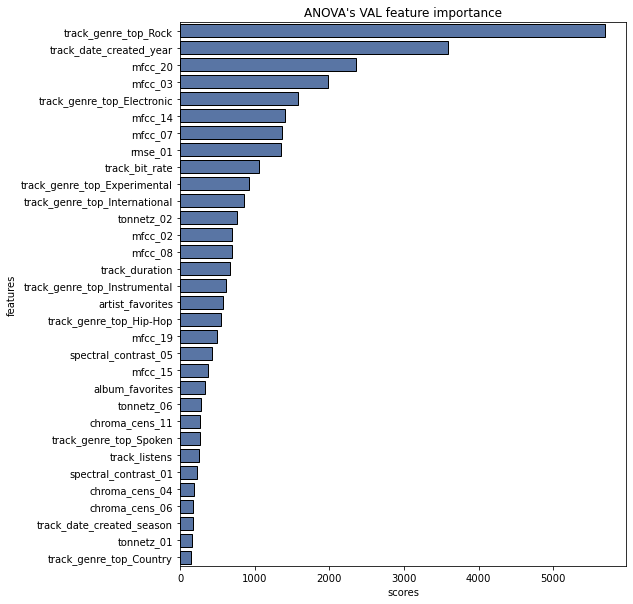

In [112]:
anova_best_features_val, anova_best_features_scores_val = anova_feature_selection(X_train, y_train, 'VAL')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Config: {'anova__k': 32} 


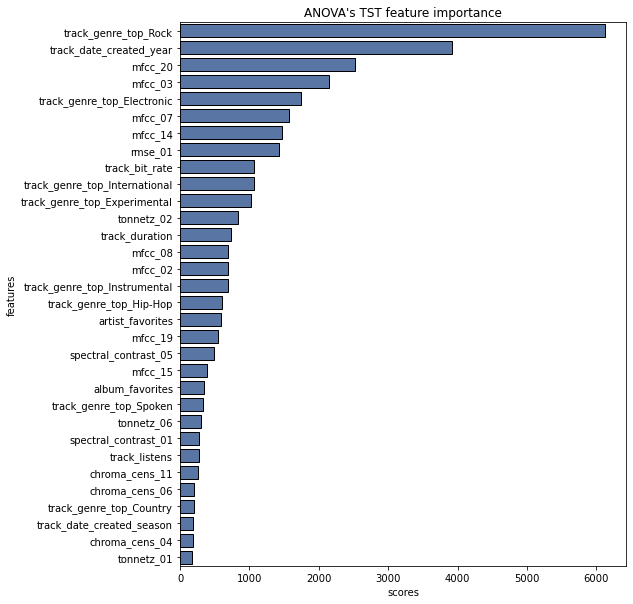

In [113]:
anova_best_features_tst, anova_best_features_scores_tst = anova_feature_selection(X_train_merged, y_train_merged, 'TST')

In [114]:
set(anova_best_features_val).difference(set(anova_best_features_tst))

set()

In [115]:
for c1, c2, i in zip(anova_best_features_val, anova_best_features_tst, range(0, len(anova_best_features_val))):
    if c1 != c2:
        print(i, c1, c2, sep="\t")

5	mfcc_14	mfcc_07
6	mfcc_07	mfcc_14
9	track_genre_top_Experimental	track_genre_top_International
10	track_genre_top_International	track_genre_top_Experimental
12	mfcc_02	track_duration
14	track_duration	mfcc_02
16	artist_favorites	track_genre_top_Hip-Hop
17	track_genre_top_Hip-Hop	artist_favorites
22	tonnetz_06	track_genre_top_Spoken
23	chroma_cens_11	tonnetz_06
24	track_genre_top_Spoken	spectral_contrast_01
26	spectral_contrast_01	chroma_cens_11
27	chroma_cens_04	chroma_cens_06
28	chroma_cens_06	track_genre_top_Country
30	tonnetz_01	chroma_cens_04
31	track_genre_top_Country	tonnetz_01


In [116]:
X_train_anova = X_train[anova_best_features_val]
X_validation_anova = X_validation[anova_best_features_val]
X_train_merged_anova = X_train_merged[anova_best_features_tst]
X_test_anova = X_test[anova_best_features_tst]

In [117]:
# saving our dataset of file
X_train_anova.to_csv('../../data/fma_metadata/X_train_anova.csv', index=True, header=True)
X_validation_anova.to_csv('../../data/fma_metadata/X_validation_anova.csv', index=True, header=True)
X_train_merged_anova.to_csv('../../data/fma_metadata/X_train_merged_anova.csv', index=True, header=True)
X_test_anova.to_csv('../../data/fma_metadata/X_test_anova.csv', index=True, header=True)

<h2>RFE (Recursive Feature Elimination) (wrapper method)</h2>

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

RFE **requires a nested algorithm that is used to provide the feature importance scores**, such
as a decision tree (**feature_importances_ attribute**) or a linear model(**coef_ attribute**).

Feature importance refers to techniques that assign a score to input features based on how
useful they are at predicting a target variable:
- statistical correlation scores;
- coefficients calculated as part of linear models or decision trees;
- permutation importance scores.

<u> RFECV automatic select best k number of features </h6>

In [118]:
from sklearn.feature_selection import RFE

In [119]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42
n_splits = 3

color = "#4C72B0"

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

def rfe_feature_selection(X_tr, y_tr, v_or_t_flag):
    cv = StratifiedKFold(n_splits=n_splits)
    rfe = RFE(estimator=DecisionTreeClassifier())
    pipeline = Pipeline(steps=[('rfe', rfe)])

    # define the grid to search:
    grid = dict()                          
    grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
    grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]

    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=False, random_state=random_state)
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())

    # summarize best
    params = results.best_params_
    print('Best Config: %s ' % params)
    best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results,
                                                                                   'rfe__n_features_to_select')

    return best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Config: {'rfe__n_features_to_select': 30, 'rfe__estimator': LogisticRegression(max_iter=10000)} 


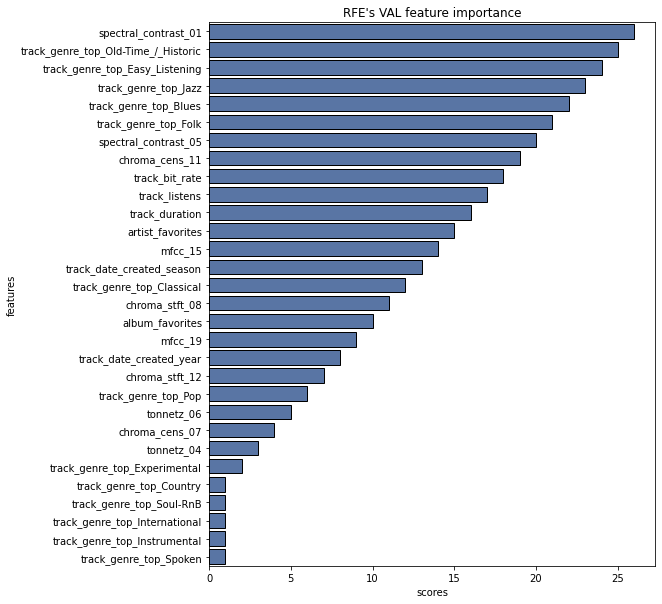

In [121]:
rfe_best_features_val, rfe_best_features_scores_val = rfe_feature_selection(X_train, y_train, 'VAL')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Config: {'rfe__n_features_to_select': 30, 'rfe__estimator': LogisticRegression(max_iter=10000)} 


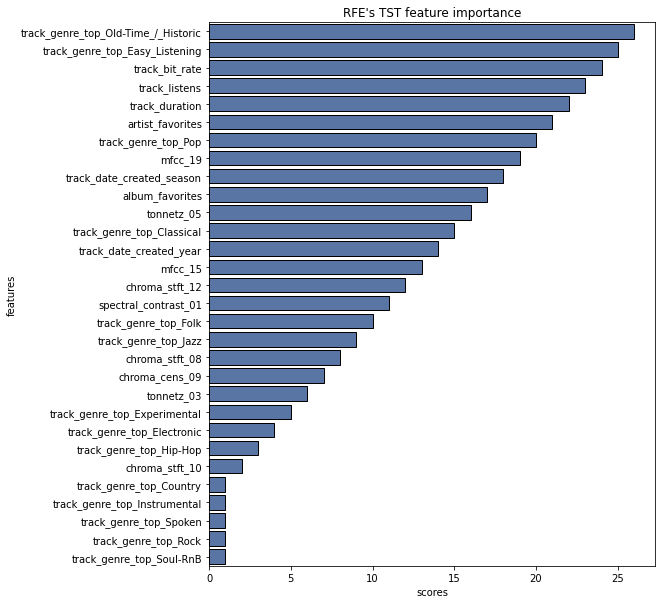

In [122]:
rfe_best_features_tst, rfe_best_features_scores_tst = rfe_feature_selection(X_train_merged, y_train_merged, 'TST')

In [123]:
set(rfe_best_features_val).difference(set(rfe_best_features_tst))

{'chroma_cens_07',
 'chroma_cens_11',
 'spectral_contrast_05',
 'tonnetz_04',
 'tonnetz_06',
 'track_genre_top_Blues',
 'track_genre_top_International'}

In [124]:
set(rfe_best_features_tst).difference(set(rfe_best_features_val))

{'chroma_cens_09',
 'chroma_stft_10',
 'tonnetz_03',
 'tonnetz_05',
 'track_genre_top_Electronic',
 'track_genre_top_Hip-Hop',
 'track_genre_top_Rock'}

In [125]:
X_train_rfe = X_train[rfe_best_features_val]
X_validation_rfe = X_validation[rfe_best_features_val]
X_train_merged_rfe = X_train_merged[rfe_best_features_tst]
X_test_rfe = X_test[rfe_best_features_tst]

In [126]:
# saving our dataset of file
X_train_rfe.to_csv('../../data/fma_metadata/X_train_rfe.csv', index=True, header=True)
X_validation_rfe.to_csv('../../data/fma_metadata/X_validation_rfe.csv', index=True, header=True)
X_train_merged_rfe.to_csv('../../data/fma_metadata/X_train_merged_rfe.csv', index=True, header=True)
X_test_rfe.to_csv('../../data/fma_metadata/X_test_rfe.csv', index=True, header=True)

<h1>Imbalanced problem</h1>

Imbalanced datasets are those where there is a severe skew in the class distribution, such as
1:100 or 1:1000 examples in the minority class to the majority class. This bias in the training
dataset can influence many machine learning algorithms, leading some to ignore the minority
class entirely.

As it follows TRN1, VAL, TRN2 and TST are imabalanced.

In [127]:
def sns_countplot(df, column_name, ax, log_flag, horizontal_flag, v_or_t_flag):
      
    # create a list to collect the plt.patches data
    percentages = []
    # find the values and append to list
    for value in reversed(df[column_name].value_counts().index):
        perc = df[df[column_name] == value].shape[0] / df.shape[0]*100
        percentages.append(perc)
    
    if horizontal_flag:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(y=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(y=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
        
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
            
        # set individual bar lables using above list
        for i, perc  in zip(ax.patches, percentages):
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+100, i.get_y()+.18, "%.1f%%" % perc)
        # invert for largest on top 
        ax.invert_yaxis()
        
    else:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(x=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(x=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
            
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
        plt.xticks(sorted(list(df[column_name].dropna().unique())))
        
    plt.title("%s %s distribution" % (str(column_name), v_or_t_flag))
    if "AxesSubplot" not in str(ax):
        plt.show()

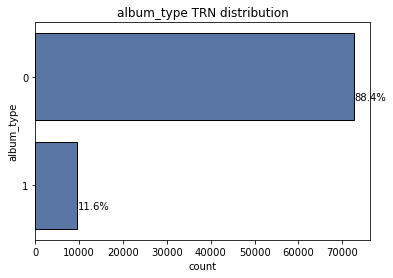

In [128]:
column_name = 'album_type'
sns_countplot(y_train, column_name, "", False, True, 'TRN')

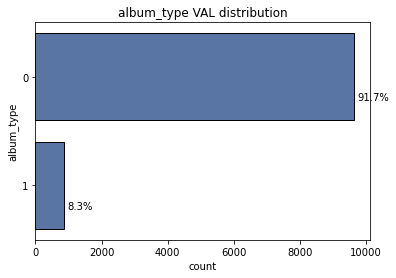

In [129]:
column_name = 'album_type'
sns_countplot(y_validation, column_name, "", False, True, 'VAL')

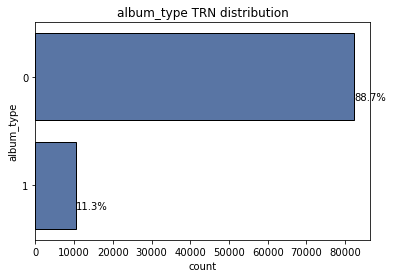

In [130]:
column_name = 'album_type'
sns_countplot(y_train_merged, column_name, "", False, True, 'TRN')

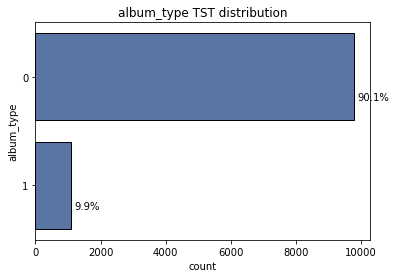

In [131]:
column_name = 'album_type'
sns_countplot(y_test, column_name, "", False, True, 'TST')